## Subject 2: Text NewsGroup Classification
1. Download the newsgroups data set using the code below. 
2. Construct a text classifier that predicts the target variable (newsgroups.target) from the input data (newsgroups.data).
3. We will evaluate your classifier against a hold-out data set, so be sure to construct a classification function that can receive a single string.

In [22]:

#Ne uităm peste date și facem niște statistici generale

from sklearn.datasets import fetch_20newsgroups
newsgroups = fetch_20newsgroups(subset='train')

print("Number of articles: " + str(len(newsgroups.data)))
print("Number of diffrent categories: " + str(len(newsgroups.target_names)))

newsgroups.target_names

Number of articles: 11314
Number of diffrent categories: 20


['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [23]:
newsgroups.target[:4]

array([7, 4, 4, 1])

In [24]:
newsgroups.data[:4]

["From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n",
 "From: guykuo@carson.u.washington.edu (Guy Kuo)\nSubject: SI Clock Poll - Final Call\nSummary: Final call for SI clock reports\nKeywords: SI,acceleration,clock,upgrade\nArticle-I.D.: shelley.1qvfo9INNc3s\nOrganization: University of Washington\nLines: 

In [25]:
# Vedem conținutul unui document
print("\n".join(newsgroups.data[1111].split("\n")[:]))

From: toml@miles.ca.boeing.com (Tom Locke)
Subject: $22600 Subaru SVX -  Good deal?
Organization: BoGART Graphics Development
Lines: 20

Hi netters,

My friend is seriously thinking of getting the Subaru SVX. There is
a local dealer here in Seattle selling them for $22600, with
Touring package, that's $7400 off from MSRP. He thinks it's a 
very good deal (and I think so too). Since he knows I have access to
the net, he would like to get anyone's opinion about this car, especially
in the area of reliability and maintenanability.
Please send e-mail to me as my friend doesn't have access to the net.

My opinion about this car is, you get a lot for $22600:
auto everything (tranny, climate control, windows, locks, folddow rear seet),
full wheel drive, 2+2, fast (143 top spped), heavy (3580lb);-)

Thanks in advacne!
-- 
Tom Locke                         Work: (206) 865-6568
Boeing Computer Services        E-mail: toml@voodoo.boeing.com 
P.O. Box 24346  M/S 7K-20           or: uunet!bcstec!vo

In [ ]:
#Fiecare document este un text scris în engleză sub forma unui e-mail cu o mulțime de punctuații.
#Prima oară se efectuează unele preprocesari, apoi ne vom concentra doar pe model.

In [54]:
html_detector = re.compile('<.*?>',flags=re.UNICODE)
punctuation_detector = re.compile('[\W_ ]',flags=re.UNICODE)

def drop_html(texts):
  return [re.sub(html_detector,' ',text) for text in texts]

def to_lowercase(texts):
  return [text.lower() for text in texts]

def drop_punctuation(texts):
  return [re.sub(punctuation_detector,' ',text) for text in texts]

def tokenize(texts):
 
  return [text.split(" ") for text in texts]

def drop_whitespaces(texts):
 
  return [[word for word in text if not word.isspace() and len(word)>0 ] for text in texts]

stemmer = SnowballStemmer('english')
def stem(texts):
  
  return [[stemmer.stem(word) for word in text] for text in texts]

def identity(x):
  return x

def compose(functions):
    return functools.reduce(lambda f, g: lambda x: f(g(x)), functions, lambda x: x)

def get_preprocessing_pipeline():
  steps = [stem,drop_whitespaces,tokenize,to_lowercase,drop_punctuation,drop_html]
  return compose(steps)

preprocessing_pipeline = get_preprocessing_pipeline()
preprocessing_pipeline(["Sa vedem cum  <br> functioneaza functiile definite mai sus","Requires padding"])


[['sa', 'vedem', 'cum', 'functioneaza', 'functiil', 'definit', 'mai', 'sus'],
 ['requir', 'pad']]

In [26]:
#Definim funcția de antrenament
#În timp ce construim un model, trebuie să reținem că primul model nu este niciodată cel mai bun,
#așa că cele mai bune practici sunt metoda „încercare și eroare”. 
#Pentru a simplifica acest proces, ar trebui să creăm o funcție pentru instruire și, în fiecare 
#încercare, să salvăm rezultate și precizii. O definim astfel:
from sklearn.model_selection import train_test_split
import time

def train(classifier, X, y):
    start = time.time()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

    classifier.fit(X_train, y_train)
    end = time.time()

    print("Accuracy: " + str(classifier.score(X_test, y_test)) + ", Time duration: " + str(end - start))
    return classifier

In [27]:
#Construim un clasificator de text (text classifier)

#Acum construim un clasificator.
#Vom incepe cu cel mai comun: clasificatorul multinomial Naive Bayes, potrivit pentru clasificarea 
#discretă. Scikit-learn are o clasă numită Pipeline, care ne permite să creăm o conductă pentru un 
#clasificator, adică putem adăuga doar funcțiile pe care dorim să le utilizăm pe datele de intrare.
#Aici, folosim un TfidfVectorizer () ca vectorizator și Multinomial ca clasificator:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

trial1 = Pipeline([ ('vectorizer', TfidfVectorizer()), ('classifier', MultinomialNB())])

train(trial1, newsgroups.data, newsgroups.target)

Accuracy: 0.8488731771984092, Time duration: 5.2815446853637695


Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [28]:

 import nltk

In [29]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\TM\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [30]:
#Scalarea parametrilor
#Am obținut o mare precizie pentru prima încercare.
#Dar să încercăm să o îmbunătățim. Putem elimina cuvintele de oprire, adică îi spunem lui  TF-IDF să 
#ignore majoritatea cuvintelor comune cu un parametru stop_words. Lista cuvintelor de oprire pot fi găsite în nltk:

from nltk.corpus import stopwords

trial2 = Pipeline([ ('vectorizer', TfidfVectorizer(stop_words=stopwords.words('english'))),('classifier', MultinomialNB())])

train(trial2, newsgroups.data, newsgroups.target)

Accuracy: 0.8775961113566063, Time duration: 5.047452211380005


Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves'...
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                   

In [68]:
#Precizia este mai bună și chiar antrenamentul este mai rapid, dar parametrul alfa al clasificatorului
#Naive-Bayes este în continuare unul implicit, deci să schimbăm valoarea acestuia și să-l repetăm 
#printr-o serie de valori:

for alpha in [5]:
    trial3 = Pipeline([('vectorizer', TfidfVectorizer(stop_words=stopwords.words('english'))),('classifier', MultinomialNB(alpha=alpha))])

train(trial3, newsgroups.data, newsgroups.target)

Accuracy: 0.8448275862068966, Time duration: 5.875654220581055


Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves'...
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                   

In [69]:
for alpha in [0.5]:
    trial3 = Pipeline([('vectorizer', TfidfVectorizer(stop_words=stopwords.words('english'))),('classifier', MultinomialNB(alpha=alpha))])

train(trial3, newsgroups.data, newsgroups.target)

Accuracy: 0.8909814323607427, Time duration: 6.810450077056885


Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves'...
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                   

In [70]:
for alpha in [0.05]:
    trial3 = Pipeline([('vectorizer', TfidfVectorizer(stop_words=stopwords.words('english'))),('classifier', MultinomialNB(alpha=alpha))])

train(trial3, newsgroups.data, newsgroups.target)

Accuracy: 0.9122015915119364, Time duration: 6.486083030700684


Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves'...
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                   

In [71]:
for alpha in [0.005]:
    trial3 = Pipeline([('vectorizer', TfidfVectorizer(stop_words=stopwords.words('english'))),('classifier', MultinomialNB(alpha=alpha))])

train(trial3, newsgroups.data, newsgroups.target)

Accuracy: 0.9175066312997348, Time duration: 6.5246522426605225


Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves'...
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
              

In [72]:
for alpha in [0.0005]:
    trial3 = Pipeline([('vectorizer', TfidfVectorizer(stop_words=stopwords.words('english'))),('classifier', MultinomialNB(alpha=alpha))])

train(trial3, newsgroups.data, newsgroups.target)

Accuracy: 0.9169761273209549, Time duration: 7.406962633132935


Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves'...
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
              

In [73]:
#Putem vedea că cea mai bună precizie de 91,75% este obținută pentru alfa 0,005. Să ignorăm cuvintele
#care apar de mai puțin de 5 ori în toate documentele și să folosim parametrul min_dif:
trial4 = Pipeline([ ('vectorizer', TfidfVectorizer(stop_words=stopwords.words('english'), min_df=5)), ('classifier', MultinomialNB(alpha=0.005)) ])

train(trial4, newsgroups.data, newsgroups.target) 

Accuracy: 0.910079575596817, Time duration: 5.906652450561523


Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=5, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves'...
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
              

In [35]:
#Precizia care rezultă este puțin mai mică, așa că aceasta a fost o idee rea. Putem încerca și pune
#datele cu nltk folosind parametrul tokenizer în TfidfVectorizer și putem adăuga punctuația la lista 
#de cuvinte de oprite:
import nltk

In [36]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\TM\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [38]:

import string
from nltk.stem import PorterStemmer
from nltk import word_tokenize

def stemming_tokenizer(text):
    stemmer = PorterStemmer()
    return [stemmer.stem(w) for w in word_tokenize(text)]

trial5 = Pipeline([ ('vectorizer', TfidfVectorizer(tokenizer=stemming_tokenizer, stop_words=stopwords.words('english') + list(string.punctuation))), ('classifier', MultinomialNB(alpha=0.005))])

train(trial5, newsgroups.data, newsgroups.target)

C:\Users\TM\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", '``', 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', "n't", 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Accuracy: 0.9151568714096332, Time duration: 97.71504640579224


Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves'...
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
   

In [ ]:
#Acuratețea este mai bună, dar training ul dureaza de 17 ori mai mult. Uneori precizia ne poate costa
#viteza de calcul și ar trebui să găsim un echilibru între ele. 

In [39]:
#Încercăm și alte clasificatoare (text classifier)

#SGDClassifier
from sklearn.linear_model import SGDClassifier
from nltk.corpus import stopwords
for classifier in [SGDClassifier()]:
    trial6 = Pipeline([('vectorizer', TfidfVectorizer(stop_words=stopwords.words('english') + list(string.punctuation))), ('classifier', classifier)])

train(trial6, newsgroups.data, newsgroups.target)

Accuracy: 0.9279717189571366, Time duration: 6.032527208328247


Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves'...
                 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
                            

In [75]:
#LinearSVC
from sklearn.svm import LinearSVC
for classifier in [LinearSVC()]:
    trial6 = Pipeline([('vectorizer', TfidfVectorizer(stop_words=stopwords.words('english') + list(string.punctuation))), ('classifier', classifier)])

train(trial6, newsgroups.data, newsgroups.target)

Accuracy: 0.9320954907161804, Time duration: 13.642333507537842


Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves'...
                                             'it', "it's", 'its', 'itself', ...],
                                 strip_accents=None, sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 

In [ ]:
#O precizie de 93,2% pentru SVC liniar este minunată! Precizia acceptabilă depinde de problema
#specifică: tipul / lungimea textul analizat, numărul de categorii și diferențele dintre ele, etc. 
#Aici, o precizie de 93% este bună pentru că avem 20 de categorii, iar unele dintre ele sunt destul 
#de similare, cum ar fi comp.sys.ibm.pc.hardware și comp.sys.mac.hardware în comparație cu Alt.atheism.

Accuracy: 0.9352785145888595, Time duration: 27.627860069274902


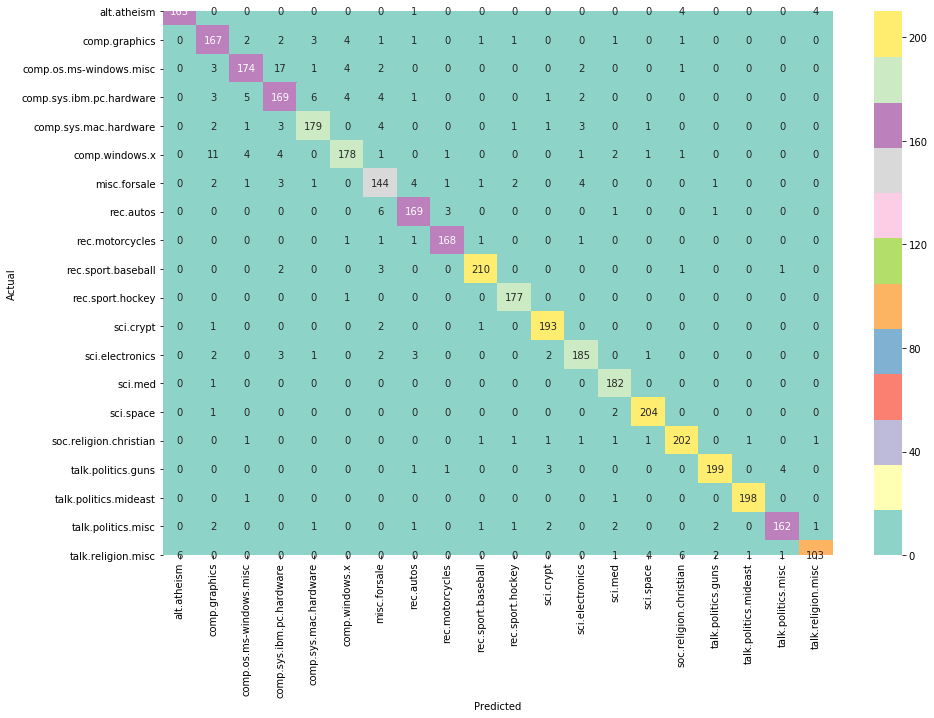

In [76]:
#Evaluarea modelului
#Ne vom opri aici și vom verifica caracteristicile celui mai bun model.
#Vom folosi confusion_matrix () din sckit-learn pentru a compara categorii reale și prezise:

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


start = time.time()
classifier = Pipeline([('vectorizer', TfidfVectorizer(stop_words=stopwords.words('english') + list(string.punctuation))),('classifier', LinearSVC(C=10))])
X_train, X_test, y_train, y_test = train_test_split(newsgroups.data, newsgroups.target, test_size=0.2, random_state=11)
classifier.fit(X_train, y_train)
end = time.time()

print("Accuracy: " + str(classifier.score(X_test, y_test)) + ", Time duration: " + str(end - start))

from sklearn.metrics import confusion_matrix
labels=newsgroups.target_names

y_pred = classifier.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)

# Plot confusion_matrix
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(conf_mat, annot=True, cmap = "Set3", fmt ="d", xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()



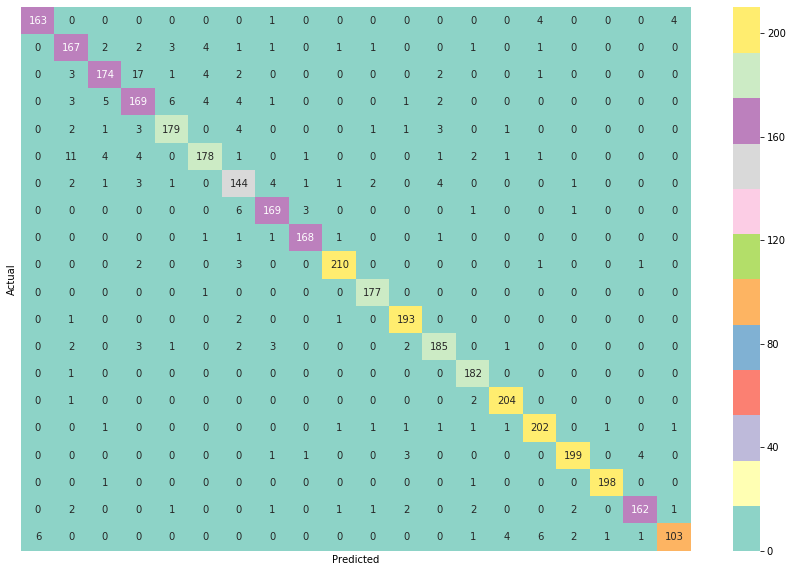

In [55]:
from sklearn.metrics import confusion_matrix
labels=[]

y_pred = classifier.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)

# Plot confusion_matrix
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(conf_mat, annot=True, cmap = "Set3", fmt ="d", xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
#Mai facem inca o data confusion matrix, dar de data aceasta fara etichete pentru a vedea mai bine datele

In [62]:
 #Verificăm exact acuratetea fiecărei categorii separat cu classification_report():
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=labels))

                          precision    recall  f1-score   support

             alt.atheism       0.96      0.95      0.96       172
           comp.graphics       0.86      0.91      0.88       184
 comp.os.ms-windows.misc       0.92      0.85      0.89       204
comp.sys.ibm.pc.hardware       0.83      0.87      0.85       195
   comp.sys.mac.hardware       0.93      0.92      0.93       195
          comp.windows.x       0.93      0.87      0.90       204
            misc.forsale       0.85      0.88      0.86       164
               rec.autos       0.93      0.94      0.93       180
         rec.motorcycles       0.97      0.97      0.97       173
      rec.sport.baseball       0.97      0.97      0.97       217
        rec.sport.hockey       0.97      0.99      0.98       178
               sci.crypt       0.95      0.98      0.96       197
         sci.electronics       0.93      0.93      0.93       199
                 sci.med       0.94      0.99      0.97       183
         